In [7]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Automatic differentiation of RNA circuit dynamics

# Imports

In [8]:
import numpy as np
import jax
import jax.numpy as jnp
from jax import random
import optax
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import diffrax as dfx
from typing import List

from functools import partial
import os
import sys

from bioreaction.simulation.simfuncs.basic_de import one_step_de_sim_expanded

jax.config.update('jax_platform_name', 'cpu')

if __package__ is None:

    module_path = os.path.abspath(os.path.join('..'))
    sys.path.append(module_path)

    __package__ = os.path.basename(module_path)


os.environ['EQX_ON_ERROR']='breakpoint'
os.environ['JAX_DISABLE_JIT']='1'

np.random.seed(0)
jax.devices()

[CpuDevice(id=0)]

In [9]:
from synbio_morpher.srv.parameter_prediction.simulator import make_piecewise_stepcontrol
from synbio_morpher.utils.misc.type_handling import flatten_listlike
from synbio_morpher.utils.modelling.physical import eqconstant_to_rates, equilibrium_constant_reparameterisation
from synbio_morpher.utils.modelling.deterministic import bioreaction_sim_dfx_expanded
from synbio_morpher.utils.modelling.solvers import get_diffrax_solver, make_stepsize_controller, simulate_steady_states
from synbio_morpher.utils.results.analytics.timeseries import calculate_adaptation, compute_peaks, compute_adaptability_full
from bioreaction.simulation.simfuncs.basic_de import bioreaction_sim, bioreaction_sim_expanded, one_step_de_sim_expanded


# Set up test environment

In [10]:
def make_species_bound(species_unbound):
    return sorted(set(flatten_listlike([['-'.join(sorted([x, y])) for x in species_unbound] for y in species_unbound])))


# RNA circuit settings
species_unbound = ['RNA_0', 'RNA_1', 'RNA_2']
species_bound = make_species_bound(species_unbound)
species = species_unbound + species_bound
species_signal = ['RNA_0']
species_output = ['RNA_2']
# species_output = ['RNA_1', 'RNA_2']
species_nonsignal = [s for s in species_unbound if s not in species_signal]
idxs_signal = np.array([species.index(s) for s in species_signal])
idxs_output = np.array([species.index(s) for s in species_output])
idxs_unbound = np.array([species.index(s) for s in species_unbound])
idxs_bound = np.array([species.index(s) for s in species_bound])
signal_onehot = np.array([1 if s in idxs_signal else 0 for s in np.arange(len(species))])

# Circuit parameters
n_circuits = 5000
n_circuits_display = 30
key = random.PRNGKey(0)
N0 = 200
y00 = np.array([[N0] * len(species_unbound) + [0] * len(species_bound)]).astype(np.float32)
y00 = np.repeat(y00, repeats=n_circuits, axis=0)

# Dynamic Simulation parameters
k_a = 0.00150958097
signal_target = 2
t0 = 0
t1 = 0.05
ts = np.linspace(t0, t1, 500)
tmax = 1000
dt0 = 0.0005555558569638981
dt1_factor = 5
dt1 = dt0 * dt1_factor
max_steps = 16**4 * 10
use_sensitivity_func1 = False
sim_method = 'Dopri8'
stepsize_controller = 'adaptive'
threshold_steady_state = 0.01
batch_size = 100
n_steps = 1000                   # Number of optimization steps

# Reactions
energies = random.normal(key, (n_circuits, len(np.tril_indices(len(species_unbound))[0])))
energies = np.interp(energies, (energies.min(), energies.max()), (-25, 0))
eqconstants = jax.vmap(partial(equilibrium_constant_reparameterisation, initial=N0))(energies)
forward_rates, reverse_rates = eqconstant_to_rates(eqconstants, k_a)
forward_rates = forward_rates[0]

inputs = np.array([
    [2, 0, 0, 0, 0, 0, 0, 0, 0],
    [1, 1, 0, 0, 0, 0, 0, 0, 0],
    [1, 0, 1, 0, 0, 0, 0, 0, 0],
    [0, 2, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, 1, 0, 0, 0, 0, 0, 0],
    [0, 0, 2, 0, 0, 0, 0, 0, 0],
], dtype=np.float64)
outputs = np.array([
    [0, 0, 0, 1, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 1, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 1, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 1, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 1, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 1],
], dtype=np.float64)

# ODE functions

In [13]:
def obj_s(deriv, y, y0):
    return - jnp.divide(deriv * jnp.power(y - y0, 2), y0)


def obj_p(y, y0):
    return jnp.divide(jnp.power(y - y0, 2), y0)


def bioreaction_sim_expanded(t, y,
                             args,
                             inputs, outputs,
                             #  signal, signal_onehot: jnp.ndarray,
                             forward_rates=None, reverse_rates=None):
    y_t, ddy_dt = y
    dy_dt = one_step_de_sim_expanded(
        y_t, inputs=inputs,
        outputs=outputs,
        forward_rates=forward_rates,
        reverse_rates=reverse_rates)
    ddy_dt = jax.jacobian(one_step_de_sim_expanded)(
        y_t, inputs=inputs,
        outputs=outputs,
        forward_rates=forward_rates,
        reverse_rates=reverse_rates)
    return dy_dt, ddy_dt
    # return dy_dt, y_sens, y_prec


def bioreaction_sim_dfx_expanded(y0, t0, t1, dt0,
                                 inputs, outputs, forward_rates, reverse_rates,
                                 solver=dfx.Tsit5(),
                                 saveat=dfx.SaveAt(
                                     t0=True, t1=True, steps=True),
                                 max_steps=16**5,
                                 stepsize_controller=dfx.ConstantStepSize()):
    if type(stepsize_controller) == dfx.StepTo:
        dt0 = None
    term = dfx.ODETerm(
        partial(bioreaction_sim_expanded,
                inputs=inputs, outputs=outputs,
                forward_rates=forward_rates.squeeze(), reverse_rates=reverse_rates.squeeze()
                )
    )
    y00 = (y0, jnp.zeros_like(y0))
    sol = dfx.diffeqsolve(term, solver,
                          t0=t0, t1=t1, dt0=dt0,
                          y0=y00,
                          #   args=args,
                          saveat=saveat, max_steps=max_steps,
                          stepsize_controller=stepsize_controller)
    # ddy_dt = jax.jacobian(sol.ys[0])
    ddy_dt = sol.ys[1]
    y_sens = obj_s(ddy_dt, sol.ys[0], y0)
    y_prec = obj_p(sol.ys[0], y0)
    return sol.ts, (sol.ys, y_sens, y_prec)


sim_func = jax.vmap(partial(bioreaction_sim_dfx_expanded,
                            t0=t0, t1=t1, dt0=dt0,
                            forward_rates=forward_rates,
                            inputs=inputs,
                            outputs=outputs,
                            solver=get_diffrax_solver(sim_method),
                            saveat=dfx.SaveAt(ts=jnp.linspace(t0, t1, 500)),
                            stepsize_controller=make_stepsize_controller(t0, t1, dt0, dt1, choice=stepsize_controller)))
# sim_func = partial(bioreaction_sim_expanded,
#                    inputs=inputs, outputs=outputs,
#                    forward_rates=forward_rates.squeeze()
#                    )

# sim_func = partial(one_step_de_sim_expanded,
#                    inputs=inputs,
#                    outputs=outputs,
#                    forward_rates=forward_rates)  # + signal(t) * signal_onehot

In [ ]:
jax.jacrev(one_step_de_sim_expanded)(
        y00[0], inputs=inputs,
        outputs=outputs,
        forward_rates=forward_rates,
        reverse_rates=reverse_rates[0])

Array([[-1.8114973, -0.3019162, -0.3019162,        nan,        nan,
               nan,        nan,        nan,        nan],
       [-0.3019162, -1.8114973, -0.3019162,        nan,        nan,
               nan,        nan,        nan,        nan],
       [-0.3019162, -0.3019162, -1.8114972,        nan,        nan,
               nan,        nan,        nan,        nan],
       [ 0.6038324,  0.       ,  0.       ,        nan,        nan,
               nan,        nan,        nan,        nan],
       [ 0.3019162,  0.3019162,  0.       ,        nan,        nan,
               nan,        nan,        nan,        nan],
       [ 0.3019162,  0.       ,  0.3019162,        nan,        nan,
               nan,        nan,        nan,        nan],
       [ 0.       ,  0.6038324,  0.       ,        nan,        nan,
               nan,        nan,        nan,        nan],
       [ 0.       ,  0.3019162,  0.3019162,        nan,        nan,
               nan,        nan,        nan,        nan],


In [14]:



# def ode_sp(t, y, args):
#     params, y0 = args
#     y_t, y_sens, y_prec = y
#     y_t = y
#     dy = sim_func(t, y_t, args, reverse_rates=params)
#     # dy_dt = jax.grad(sim_func, argnums=1)(t, y_t, args, reverse_rates=params)
#     # y_sens = jax.grad(obj_s)(dy, y_t, y0)
#     # y_prec = jax.grad(obj_p)(y_t, y0)
#     return dy, y_sens, y_prec



# Solve the ODE with an auxiliary variable to track the max
# def r(y0, params):
#     solution = dfx.diffeqsolve(
#         dfx.ODETerm(ode_sp),
#         solver=get_diffrax_solver(sim_method),
#         t0=t0,
#         t1=t1,
#         dt0=dt0,
#         y0=y0,
#         # y0=(y0, y0, y0),
#         args=(params, y0),  # Pass params and initial max as args
#         saveat=dfx.SaveAt(ts=jnp.linspace(t0, t1, max_steps)),
#         stepsize_controller=make_stepsize_controller(t0, t1, dt0, dt1,
#                                                         choice=stepsize_controller)
#         # adjoint=dfx.BacksolveAdjoint()  # This enables differentiation
#     )
#     return solution


y0 = y00[:10]
params = reverse_rates[:10]

ts, ys = sim_func(y0=y0, reverse_rates=params)

ValueError: `terms` must be a PyTree of `AbstractTerms` (such as `ODETerm`), with structure <class 'diffrax._term.AbstractTerm'>

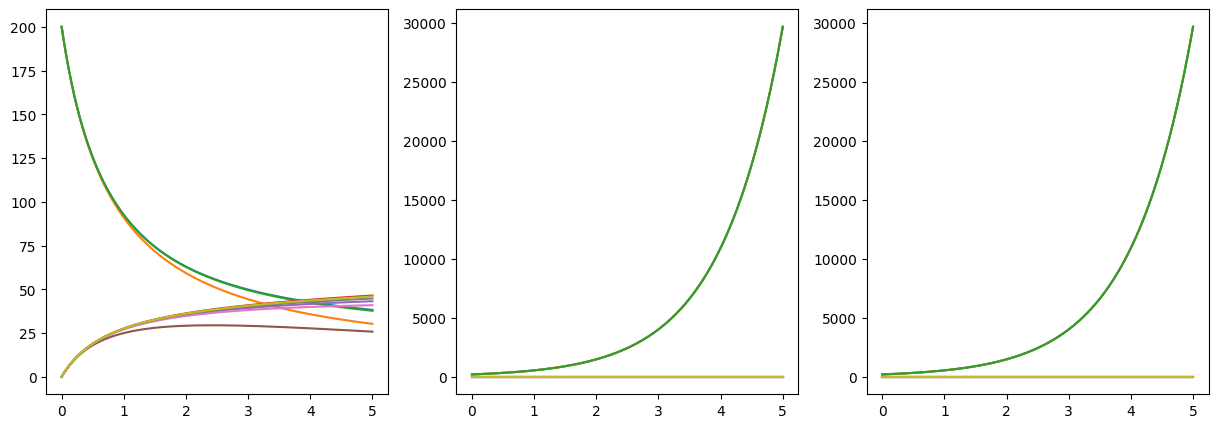

In [ ]:
plt.figure(figsize=(15, 5))
for i in range(3):
    ax = plt.subplot(1, 3, i+1)
    plt.plot(ts[0], ys[i][0])

In [ ]:
# Define the ODE function
def ode_func(t, y, params):
    return params.sum(axis=-1) - y  # (y * params).sum(axis=-1) - y


def smooth_max(a, b, epsilon=1e-2):
    """ Smooth approximation for maximum """
    return epsilon * jnp.log(jnp.exp(a / epsilon) + jnp.exp(b / epsilon))


def smooth_max2(a, b):
    """ Smooth maximum approximation using softplus"""
    return jnp.log1p(jnp.exp(a - b)) + b  # Softplus-based approximation


def max_value_ode(t, y, args):
    """ `args` is a tuple (params, max_val) """
    params, epsilon = args
    max_val = y[1]
    dy_dt = ode_func(t, y[0], params)
    # max_val = jnp.max(jnp.vstack([max_val, y[0]]), axis=0)
    max_val = smooth_max(max_val, y[0], epsilon)
    # return dy_dt, jnp.sin(y[0])
    return dy_dt, max_val


def ode_sp(t, y, args):
    params, y0 = args
    # y_t, y_sens, y_prec = y
    y_t = y
    dy_dt = sim_func(t, y_t, args, reverse_rates=params)
    y_sens = obj_s(dy_dt, y_t, y0)
    y_prec = obj_p(y_t, y0)
    return dy_dt #, y_sens, y_prec


def obj_s(deriv, y, y0):
    return - jnp.divide(deriv * jnp.power(y - y0, 2), y0)


def obj_p(y, y0):
    return jnp.divide(jnp.power(y - y0, 2), y0)


# Modified function to solve the ODE and track the maximum value with params
def solve_ode_and_track_max(y0, params, t0, t1, dt0, dt1, stepsize_controller, max_steps=1000, idx_output=-1):

    # Solve the ODE with an auxiliary variable to track the max
    solution = dfx.diffeqsolve(
        dfx.ODETerm(ode_sp),
        solver=get_diffrax_solver(sim_method),
        t0=t0,
        t1=t1,
        dt0=dt0,
        y0=y0,
        # y0=(y0, y0, y0),
        args=(params, y0),  # Pass params and initial max as args
        saveat=dfx.SaveAt(ts=jnp.linspace(t0, t1, max_steps)),
        stepsize_controller=make_stepsize_controller(t0, t1, dt0, dt1,
                                                     choice=stepsize_controller)
        # adjoint=dfx.BacksolveAdjoint()  # This enables differentiation
    )

    y_sens, y_prec = solution.ys[1][-2:]  # Get the max value reached
    return solution, y_sens[idx_output], y_prec[idx_output]


def solve_naive(y0, params, t0, t1, dt0, max_steps=10000, idx_output=-1):

    y, y_sens, y_prec = y0, y0, y0
    # , np.zeros((max_steps, len(y0))), np.zeros((max_steps, len(y0)))
    ys, ys_sens, ys_prec = np.zeros((3, max_steps, len(y0)))
    for i_t, tstep in enumerate(np.linspace(t0, t1, max_steps)):
        dy_dt, y_sens, y_prec = ode_sp(
            tstep, (y, y_sens, y_prec), (params, y0))
        y = y + dy_dt * dt0
        ys[i_t] = y
        ys_sens[i_t] = y_sens
        ys_prec[i_t] = y_prec
    return ys, ys_sens, ys_prec


# @jax.jit
def loss_fn(params, y0, t0, t1, dt0, dt1, stepsize_controller, ):
    """ Define a loss function to optimize params """
    _, y_sens, y_prec = solve_ode_and_track_max(
        y0, params, t0, t1, dt0, dt1, stepsize_controller, )
    return (y_sens + y_prec)


# @jax.jit
def batch_loop(params_b, y0b, t0, t1, dt0, dt1, stepsize_controller, optimiser, opt_state):

    loss_b, grads_b = jax.value_and_grad(
        jax.vmap(partial(loss_fn, t0=t0, t1=t1, dt0=dt0, dt1=dt1, stepsize_controller=stepsize_controller)))(params_b, y0b)
    updates, opt_state = optimiser.update(grads_b, opt_state)
    params_b = optax.apply_updates(params_b, updates)

    return loss_b, grads_b, params_b


# @jax.jit
def optimise_step(params, opt_state, y0, t0, t1, dt0, dt1, stepsize_controller, optimiser, batch_size):
    def extend_batch(xs, xsb):
        if xs is None:
            xs = xsb
        else:
            xs = jnp.concatenate([xs, xsb])
        return xs

    loss, grads = (None, None)
    for batch_step in range(0, len(params), batch_size):
        print(f"Batch step: {batch_step}/{len(params)}")
        i0, i1 = batch_step, batch_step + batch_size
        params_b, y0b = (params[i0:i1], y0[i0:i1])

        loss_b, grads_b, params_b = batch_loop(
            params_b, y0b, t0, t1, dt0, dt1, stepsize_controller, optimiser, opt_state)

        params = jax.ops.index_update(params, jax.ops.index[i0:i1], params_b)
        loss = extend_batch(loss, loss_b)
        grads = extend_batch(grads, grads_b)
    return params, opt_state, loss, grads

In [15]:
if False:
    params = reverse_rates

    ys, ys_sens, ys_prec = partial(solve_naive, t0=t0, t1=t1, dt0=dt0)(y00[0], params[0])

    fig = plt.figure(figsize=(8*2, 6))
    ax = plt.subplot(1,2,1)
    plt.plot(np.linspace(t0, t1, 10000), ys)

    ax = plt.subplot(1,2,2)
    plt.plot(np.linspace(t0, t1, 10000), ys_sens)
    plt.plot(np.linspace(t0, t1, 10000), ys_prec)


In [16]:
params = reverse_rates

# Set up optax optimiser
optimiser = optax.adam(learning_rate=0.01)
opt_state = optimiser.init(params)

# Optimization loop
loss_all = np.zeros(n_steps)
grads_all = np.zeros((n_steps, len(params)))
for i in range(n_steps):
    print(f'Step {i}')
    params, opt_state, current_loss, current_grads = optimise_step(
        params, opt_state, y00, t0, t1, dt0, dt1, stepsize_controller, optimiser, batch_size)
    if i % 100 == 0:
        print(f"Step {i}, Loss: {current_loss}, Params: {params}")

print(f"Optimized Params: {params}")

# solution_steps, y_sens, y_prec = solve_ode_and_track_max(
#     ode_func, y00, t0, t1, params)

Step 0


EquinoxRuntimeError: Above is the stack outside of JIT. Below is the stack inside of JIT:
  File "/usr/local/lib/python3.10/dist-packages/diffrax/_integrate.py", line 1423, in diffeqsolve
    sol = result.error_if(sol, jnp.invert(is_okay(result)))
equinox.EquinoxRuntimeError: The maximum number of solver steps was reached. Try increasing `max_steps`.

-------------------

An error occurred during the runtime of your JAX program.

1) Setting the environment variable `EQX_ON_ERROR=breakpoint` is usually the most useful
way to debug such errors. This can be interacted with using most of the usual commands
for the Python debugger: `u` and `d` to move up and down frames, the name of a variable
to print its value, etc.

2) You may also like to try setting `JAX_DISABLE_JIT=1`. This will mean that you can
(mostly) inspect the state of your program as if it was normal Python.

3) See `https://docs.kidger.site/equinox/api/debug/` for more suggestions.


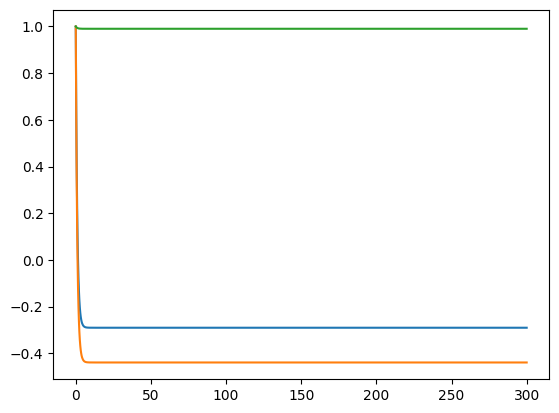

In [ ]:
plt.plot(solution_steps.ts, solution_steps.ys[0])

In [ ]:
# Comparison of Max's
x1 = jnp.ones(10) * 2.
x2 = jnp.linspace(0, 2, 10)
max_val = smooth_max(x1, x2, epsilon=1e-1)
# max_val = smooth_max2(x1, x2)
max_val, jnp.maximum(x1, x2)